<h1> <b>Homework 11</b></h1>
<i>Kuan Lin, Ricardo Barrera, Alejandro J. Rojas<br>
ale@ischool.berkeley.edu<br>
W261: Machine Learning at Scale<br>
Week: 11<br>
Apr 5, 2016, 1:15 PM</i></li>

## HW11.0  Broadcast versus Caching in Spark
##### What is the difference between broadcasting and caching data in Spark? Give an example (in the context of machine learning) of each mechanism (at a highlevel). Feel free to cut and paste code examples from the lectures to support your answer.

Review the following Spark-notebook-based implementation of KMeans and use the broadcast pattern to make this implementation more efficient. Please describe your changes in English first, implement, comment your code and highlight your changes:

Notebook
https://www.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb?dl=0

Notebook via NBViewer
http://nbviewer.ipython.org/urls/dl.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb


Caching data in Sapark is useful to keep in memory data that you need to process multiple times. An example of it would be cacg=hing a training dataset. On the other hand boradcasting is implemented whem you need to let worker nodes the status of a specific variable. For example when running logistic regression you need to broadcast the value of the weights after each iteration so that worker nodes can process gradient descent using the most current weights.

To make the K-Means code more efficient we will boradcast the values of the centroids of each cluster so that the worker nodes get that info on their own memory

# K-Means Model Modified

In [34]:
 %matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

# Data Visualization

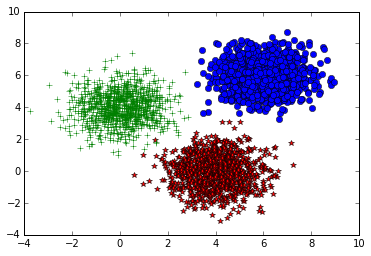

In [35]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

In [40]:
import os
import sys
#Escape L for line numbers
spark_home = os.environ['SPARK_HOME'] = '/Users/Lissette/Documents/datascience/software/spark-1.5.2-bin-hadoop2.6'
##spark_home = os.environ['SPARK_HOME'] = '/Users/jshanahan/Dropbox/Lectures-UC-Berkeley-ML-Class-2015/spark-1.5.0-bin-hadoop2.6/'
#spark_home = os.environ['SPARK_HOME'] = '/Users/james.shanahan/Dropbox/Lectures-UC-Berkeley-ML-Class-2015/spark-1.5.0-bin-hadoop2.6/'
#spark_home = os.environ['SPARK_HOME'] = '/Users/liang/Downloads/spark-1.3.0-bin-hadoop2.4/'
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by <module> at <ipython-input-8-4f7d048e0bcd>:12 

In [37]:
import numpy as np

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

In [38]:
##Distributed KMeans in Spark

Iteration0
[[ 0.91236361  0.39633139]
 [ 3.95673777  2.6480321 ]
 [ 2.11510663  5.70443409]]


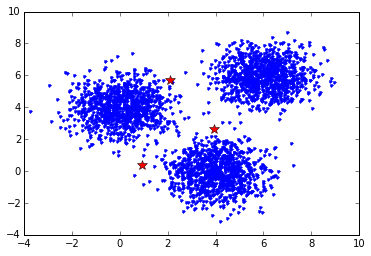

Iteration1
[[ 1.72194834  0.75343493]
 [ 5.21013713  2.46056515]
 [ 2.40605316  5.35865516]]


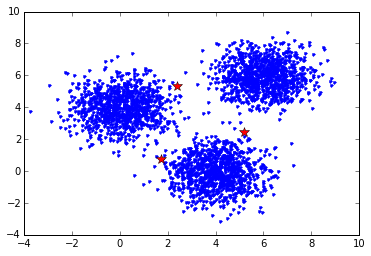

Iteration2
[[ 2.3636143   0.59541184]
 [ 5.79255841  3.17136059]
 [ 2.26878943  5.27014298]]


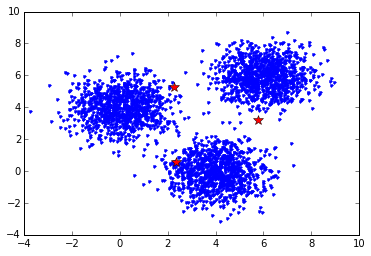

Iteration3
[[ 3.37680413  0.1414035 ]
 [ 6.20555808  5.24366665]
 [ 1.0093821   4.71392228]]


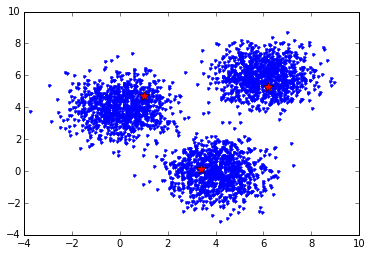

Iteration4
[[ 3.98566856 -0.04836631]
 [ 5.99499555  5.97596897]
 [ 0.05391121  4.04241775]]


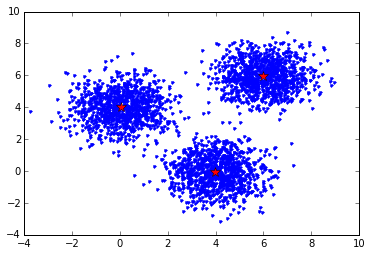

Iteration5
[[ 4.01573841 -0.05511536]
 [ 5.98103957  5.98221712]
 [ 0.04365268  4.01254729]]


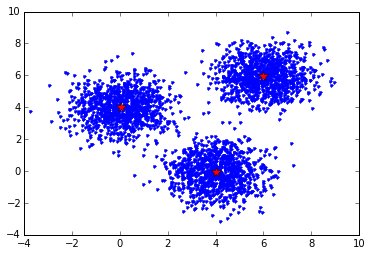

Final Results:
[[ 4.01573841 -0.05511536]
 [ 5.98103957  5.98221712]
 [ 0.04365268  4.01254729]]


In [43]:
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("./data.csv").cache()
iter_num = 0
for i in range(10):  
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    
    ####### We add the broadcasting of the centroids #########
    cBroadcast = sc.broadcast(centroids)
    #res [(0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)  ), 
    #     (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
    #     (1, (array([ 3986.85984761,    15.93153464]), 999))]
    # res[1][1][1] returns 1000 here
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    if np.sum(np.absolute(centroids_new-centroids))<0.01:
        break
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    centroids = centroids_new
    print centroids
    plot_iteration(centroids)
print "Final Results:"
print centroids

#MLlib Kmeans

In [44]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

# Load and parse the data
data = sc.textFile("data.csv")
parsedData = data.map(lambda line: array([float(x) for x in line.split(',')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 3, maxIterations=20,
        runs=10, initializationMode="random")
for centroid in clusters.centers:
    print centroid

[ 0.04365268  4.01254729]
[ 5.98103957  5.98221712]
[ 4.01573841 -0.05511536]


## End of HW11.0

## HW11.3  Logistic Regression
##### Generate 2 sets of linearly separable data with 100 data points each using the data generation code provided below and plot each in separate plots. Call one the training set and the other the testing set.

def generateData(n):
 """ 
  generates a 2D linearly separable dataset with n samples. 
  The third element of the sample is the label
 """
 xb = (rand(n)*2-1)/2-0.5
 yb = (rand(n)*2-1)/2+0.5
 xr = (rand(n)*2-1)/2+0.5
 yr = (rand(n)*2-1)/2-0.5
 inputs = []
 for i in range(len(xb)):
  inputs.append([xb[i],yb[i],1])
  inputs.append([xr[i],yr[i],-1])
 return inputs

Modify this data generation code to generating non-linearly separable training and testing datasets (with approximately 10% of the data falling on the wrong side of the separating hyperplane. Plot the resulting datasets. 

NOTE: For the remainder of this problem please use the non-linearly separable training and testing datasets.

Using MLLib  train up a LASSO logistic regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the logistic regression model? Justify with plots and words. 

Derive and implement in Spark a weighted  LASSO logistic regression. Implement a convergence test of your choice to check for termination within your training algorithm . 

Weight the above training dataset as follows:  Weight each example using the inverse vector length (Euclidean norm): 

weight(X)= 1/||X||, 

where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

Here X is vector made up of X1 and X2.

Evaluate your homegrown weighted  LASSO logistic regression on the test dataset. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge.

Does Spark MLLib have a weighted LASSO logistic regression implementation. If so use it and report your findings on the weighted training set and test set. 

#Data Generation

In [14]:
import numpy as np
import csv
def data_generate(fileName, w=[0,0,0]):
    size = 100
    np.random.seed(0)
    x1 = np.random.uniform(-4,4,100)
    x2 = np.random.uniform(-4,4,100)
    noise = np.random.normal(0,3,100)
    v = (x1 * w[0] + x2 * w[1] + w[2] + noise)
    y = (v>0) * 2-1
    data = zip(y, x1, x2)
    with open(fileName,'wb') as f:
        writer = csv.writer(f)
        for row in data:
            writer.writerow(row)
    return True

In [15]:
w = np.array([8, -3, -1])
data_generate('data.csv', w)

True

# Data Visualization

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
def dataPlot(file, w):
    cols = {'1': 'r', '-1': 'b'}
    with open(file,'r') as f:
        reader = csv.reader(f)
        for row in reader:
            plt.plot(float(row[1]), float(row[2]), cols[row[0]]+'o')
    plt.xlabel("x1")
    plt.ylabel("x2")
    x1 = [-4,4]
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    plt.plot(x1, x2, linewidth=2.0)
    plt.grid()
    plt.show()

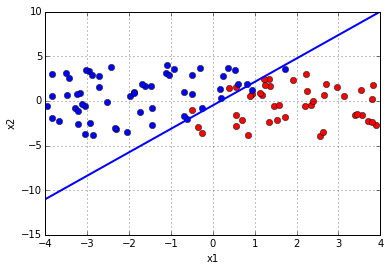

In [17]:
dataPlot('data.csv',w)

# Start Spark

In [19]:
import os
import sys
##spark_home = os.environ['SPARK_HOME'] = '/Users/liang/Downloads/spark-1.4.1-bin-hadoop2.6/'
##if not spark_home:
##    raise ValueError('SPARK_HOME enviroment variable is not set')
##sys.path.insert(0,os.path.join(spark_home,'python'))
##sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
##execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

#Gradient descent (no regularization)

In [20]:
from collections import namedtuple
import numpy as np
Point = namedtuple('Point', 'x y')

def readPoint(line):
    d = line.split(',')
    x = [float(i) for i in d[1:]]
    x.append(1.0)  #bias term
    return Point(x, float(d[0]))

def logisticRegressionGD(data, wInitial=None, learningRate=0.05, iterations=100):
    featureLen = len(data.take(1)[0].x)
    n = data.count()
    if wInitial is None:
        w = np.random.normal(size=featureLen)
    else:
        w = wInitial
    for i in range(iterations):
        wBroadcast = sc.broadcast(w)
        gradient = data.map(lambda p: (1 / (1 + np.exp(-p.y*np.dot(wBroadcast.value, p.x)))-1) * p.y * np.array(p.x))\
                    .reduce(lambda a, b: a + b)
        w = w - learningRate * gradient / n
    #w = w / np.linalg.norm(w) #normalization
    return w

In [21]:
data = sc.textFile('data.csv').map(readPoint).cache()
logisticRegressionGD(data)

array([ 1.35420091, -0.46407845, -1.01559616])

##Plot w in iterations

In [22]:
def ierationsPlot(fileName, truew):
    x1 = [-4, 4]
    
    w = truew
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    plt.plot(x1, x2, 'b', label="True line", linewidth=4.0)
    
    np.random.seed(800)
    w = np.random.normal(0,1,3)
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    plt.plot(x1, x2, 'r--', label="After 0 Iterations", linewidth=2.0)
    
    data = sc.textFile(fileName).map(readPoint).cache()
    w = logisticRegressionGD(data, w, iterations=30)
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    plt.plot(x1, x2, 'g--', label="After 1 Iterations", linewidth=2.0)
    
    w = logisticRegressionGD(data, w, iterations=30)
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    plt.plot(x1, x2, 'm--', label="After 2 Iterations", linewidth=2.0)
    
    w = logisticRegressionGD(data, w, iterations=30)
    x2 = [-(i * w[0] + w[2]) / w[1] for i in x1]
    plt.plot(x1, x2, 'y--', label="After 3 Iterations", linewidth=2.0)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, borderaxespad=0.)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid()
    plt.show()

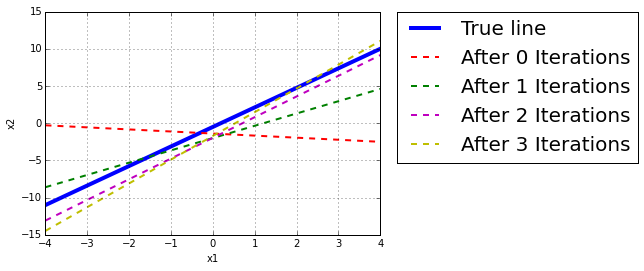

In [23]:
ierationsPlot('data.csv',w)

#Gradient descent (regularization)

In [24]:
def logisticRegressionGDReg(data, wInitial=None, learningRate=0.05, iterations=50, regParam=0.01, regType=None):
    featureLen = len(data.take(1)[0].x)
    n = data.count()
    if wInitial is None:
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:
        w = wInitial
    for i in range(iterations):
        wBroadcast = sc.broadcast(w)
        gradient = data.map(lambda p: (1 / (1 + np.exp(-p.y*np.dot(wBroadcast.value, p.x)))-1) * p.y * np.array(p.x))\
                    .reduce(lambda a, b: a + b)
        if regType == "Ridge":
            wReg = w * 1
            wReg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
        elif regType == "Lasso":
            wReg = w * 1
            wReg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
            wReg = (wReg>0).astype(int) * 2-1
        else:
            wReg = np.zeros(w.shape[0])
        gradient = gradient + regParam * wReg  #gradient:  GD of Sqaured Error+ GD of regularized term 
        w = w - learningRate * gradient / n
    return w

##Ridge  Regression

In [25]:
np.random.seed(400)
logisticRegressionGDReg(data, iterations=50, regParam=0.1, regType="Ridge")

array([ 0.74835721, -0.17134752, -0.39953122])

##Lasso  Regression

In [26]:
np.random.seed(400)
logisticRegressionGDReg(data, iterations=50, regParam=0.1, regType="Lasso")

array([ 0.74788215, -0.17092861, -0.397468  ])